<a href="https://colab.research.google.com/github/Anj2307/fraud_detect/blob/main/feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd

In [36]:
df=pd.read_csv('/content/SOI_2025_Dataset.csv')
df.head()
print(df.shape)

(1000000, 32)


Standerdization of the data means covert all string inputs to numerical one for better testing the model.

In [37]:
df.select_dtypes(include='string').columns

Index([], dtype='object')

In [38]:
from sklearn.preprocessing import LabelEncoder

# Dictionary to store mappings for all columns
encoders = {}

# Loop over all object (string) columns
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()

    # Fit and transform the column
    df[col + '_encoded'] = le.fit_transform(df[col])

    # Save the mapping
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    encoders[col] = mapping

    # Print the mapping
    print(f"\n📌 Mapping for '{col}':")
    for k, v in mapping.items():
        print(f"{k} → {v}")
print(df.shape)


📌 Mapping for 'payment_type':
AA → 0
AB → 1
AC → 2
AD → 3
AE → 4

📌 Mapping for 'employment_status':
CA → 0
CB → 1
CC → 2
CD → 3
CE → 4
CF → 5
CG → 6

📌 Mapping for 'housing_status':
BA → 0
BB → 1
BC → 2
BD → 3
BE → 4
BF → 5
BG → 6

📌 Mapping for 'source':
INTERNET → 0
TELEAPP → 1

📌 Mapping for 'device_os':
linux → 0
macintosh → 1
other → 2
windows → 3
x11 → 4
(1000000, 37)


In [39]:
import json
import numpy as np

# Convert numpy int64 to standard Python int
def convert_int64(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

with open('mapping.json', 'w') as f:
    json.dump(encoders, f, default=convert_int64)
print(df.shape)

(1000000, 37)


In [40]:
# dropping the real columns to encoded one
df['payment_type'] = df['payment_type_encoded']
df.drop('payment_type_encoded', axis=1, inplace=True)
df['employment_status'] = df['employment_status_encoded']
df.drop('employment_status_encoded', axis=1, inplace=True)
df['housing_status'] = df['housing_status_encoded']
df.drop('housing_status_encoded', axis=1, inplace=True)
df['source'] = df['source_encoded']
df.drop('source_encoded', axis=1, inplace=True)
df['device_os'] = df['device_os_encoded']
df.drop('device_os_encoded', axis=1, inplace=True)
print(df.shape)

(1000000, 32)


Generally fraudsters have most unsual activity at the time of crime. so we have weight to 6h then 4w

In [41]:

import matplotlib.pyplot as plt
import seaborn as sns

velocity_cols=['velocity_6h','velocity_24h','velocity_4w']

In [42]:
print(" Correlation with 'fraud_bool':")
print(df[velocity_cols + ['fraud_bool']].corr()['fraud_bool'].sort_values(ascending=False))

 Correlation with 'fraud_bool':
fraud_bool      1.000000
velocity_24h   -0.009810
velocity_4w    -0.010705
velocity_6h    -0.016195
Name: fraud_bool, dtype: float64


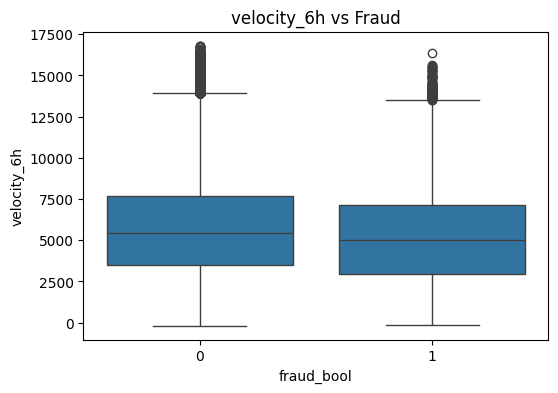

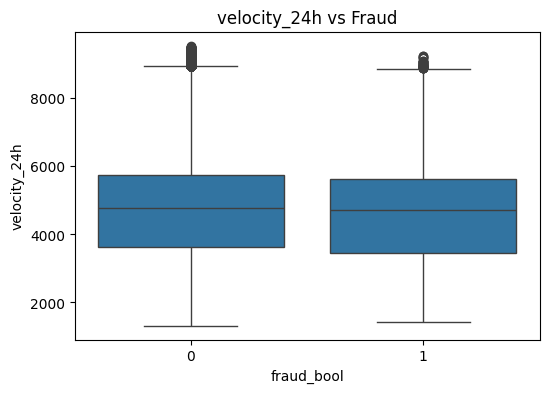

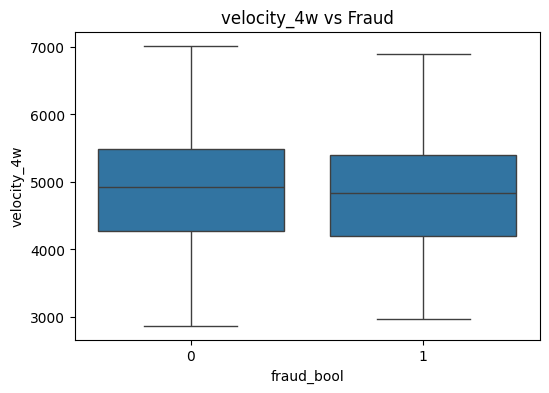

In [43]:
for col in velocity_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='fraud_bool', y=col, data=df)
    plt.title(f'{col} vs Fraud')
    plt.show()

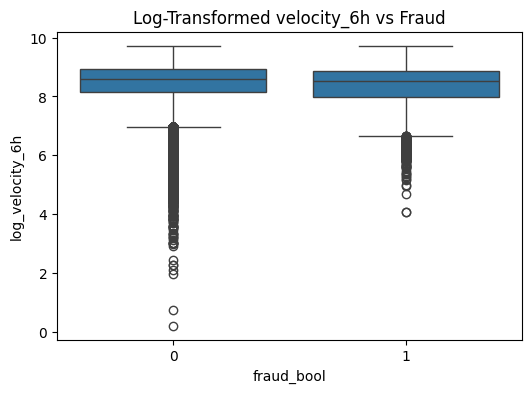

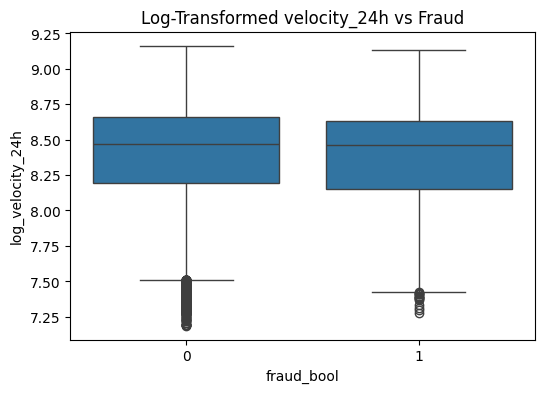

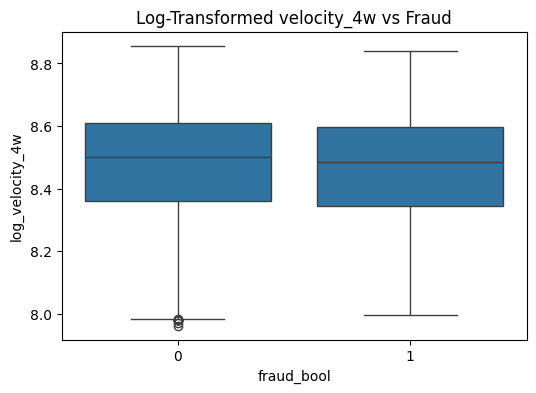

In [44]:
for col in velocity_cols:
    log_col = f'log_{col}'
    df[log_col] = np.log1p(df[col])  # log(1 + x)
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='fraud_bool', y=log_col, data=df)
    plt.title(f'Log-Transformed {col} vs Fraud')
    plt.show()

In [45]:
corrs = df[['velocity_6h', 'velocity_24h', 'velocity_4w', 'fraud_bool']].corr()['fraud_bool'][:-1]
weights = corrs / corrs.sum()
print(weights)
print(type(weights))
# Apply weighted score
df['velocity_risk_score'] = (
    weights['velocity_6h'] * df['velocity_6h'] +
    weights['velocity_24h'] * df['velocity_24h'] +
    weights['velocity_4w'] * df['velocity_4w']
)

velocity_6h     0.441166
velocity_24h    0.267222
velocity_4w     0.291612
Name: fraud_bool, dtype: float64
<class 'pandas.core.series.Series'>


In [46]:
weights_map = weights.to_dict()
print(weights_map)


{'velocity_6h': 0.44116587637656723, 'velocity_24h': 0.26722219181048107, 'velocity_4w': 0.29161193181295175}


In [47]:
import json
# saving to json file
with open("weight_map.json", "w") as f:
    json.dump(weights_map, f, indent=4)

In [48]:
df.drop(['log_velocity_6h','log_velocity_24h','log_velocity_4w'],axis=1,inplace=True)

In [49]:
print(len(df.columns.tolist()))

33


In [50]:
df.columns.tolist()

['fraud_bool',
 'income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'payment_type',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'employment_status',
 'credit_risk_score',
 'email_is_free',
 'housing_status',
 'phone_home_valid',
 'phone_mobile_valid',
 'bank_months_count',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'source',
 'session_length_in_minutes',
 'device_os',
 'keep_alive_session',
 'device_distinct_emails_8w',
 'device_fraud_count',
 'month',
 'velocity_risk_score']

i remove fraud_count as it remain 0 everywhere

In [51]:
df.drop('device_fraud_count',axis=1,inplace=True)

In [52]:
for i in df.columns.tolist():
    print(i,df[i].value_counts().get(-1,0))


fraud_bool 0
income 0
name_email_similarity 0
prev_address_months_count 759415
current_address_months_count 3488
customer_age 0
days_since_request 0
intended_balcon_amount 0
payment_type 0
zip_count_4w 0
velocity_6h 0
velocity_24h 0
velocity_4w 0
bank_branch_count_8w 0
date_of_birth_distinct_emails_4w 0
employment_status 0
credit_risk_score 435
email_is_free 0
housing_status 0
phone_home_valid 0
phone_mobile_valid 0
bank_months_count 241872
has_other_cards 0
proposed_credit_limit 0
foreign_request 0
source 0
session_length_in_minutes 2277
device_os 0
keep_alive_session 0
device_distinct_emails_8w 336
month 0
velocity_risk_score 0


In [53]:
print(df.shape)

(1000000, 32)


In [55]:
cols_with_neg1 = []

for col in df.columns:
    if (df[col] == -1).any():
        cols_with_neg1.append(col)
print(cols_with_neg1)
print(df.shape)

['prev_address_months_count', 'current_address_months_count', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
(1000000, 32)


In [57]:
for i in cols_with_neg1:
    median_val=df.loc[df[i]!=-1,i].median()
    df[i]=df[i].replace(-1,median_val)
print(df.shape)

(1000000, 32)


In [58]:
df_copy=df.copy()

In [70]:
df.drop(['velocity_6h','velocity_24h','velocity_4w'],axis=1,inplace=True)

In [71]:
from sklearn.preprocessing import StandardScaler
num_cols=df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('fraud_bool')
scaler=StandardScaler()
df[num_cols]=scaler.fit_transform(df[num_cols])

In [72]:
print(df.shape)

(1000000, 29)


In [73]:
from sklearn.model_selection import train_test_split

X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [74]:
train_data = X_train.copy()
train_data['fraud_bool'] = y_train

test_data = X_test.copy()
test_data['fraud_bool'] = y_test


In [75]:
train_data.to_csv('train_dataset.csv', index=False)
test_data.to_csv('test_dataset.csv', index=False)


In [76]:
print(X_test.shape)

(200000, 28)
